# Load data, prepare dataloader, miniEDA

torch_version: 1.7.0,
torchvision_version: 0.8.1
device: cuda:0 

train data: torch.Size([60000, 28, 28]) torch.Size([60000])
train data's type: torch.ByteTensor torch.LongTensor
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


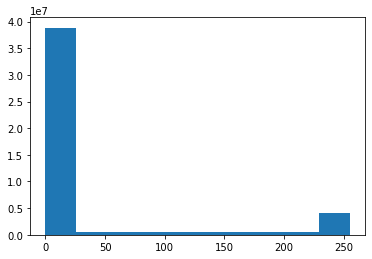

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import seaborn as sns
import plot_utils
import matplotlib.pyplot as plt
%matplotlib inline

# params
#random_seed = 1
batch_size = 32
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# prepare DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)

# info
print('torch_version: {},\ntorchvision_version: {}'.format(torch.__version__,torchvision.__version__))
print('device:', device, '\n')

print('train data:', train_set.data.shape, train_set.targets.shape)
print('train data\'s type:', train_set.data[0].type(), train_set.targets[0].type()) # torch.uint8
print(train_set.data.max(),train_set.data.min()) # torch.uint8
plt.hist(train_set.data.view(60000*28*28,1).numpy());

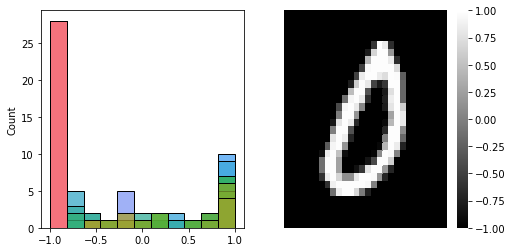

In [5]:
data_batch, labels_batch = next(iter(train_dl))[0], next(iter(train_dl))[1]

fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.heatmap(data=data_batch[7].view(28,28),cmap='gray', xticklabels=False, yticklabels=False, ax=ax[1])
sns.histplot(data_batch[7].view(28,28).numpy(), legend=False, ax=ax[0]);

# №1

In [8]:
# архитектура DCGAN

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        return x

In [9]:
# лоссы и геренация нормального распределения

def random_noise_generator(batch_size, dim):
    return torch.normal(mean=0.0, std=1.0, size=(batch_size, dim))

Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [11]:
# Функция обучения DCGAN

def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 20, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    D.train()
    G.train()
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        for (train_x,_) in train_dl:
            
            #Discriminator training
            disc_opt.zero_grad()
            train_x = train_x.to(device) 
            real_out = D(train_x.float())    
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)
            disc_gen_out = G(disc_gen_in.float()).detach()  # чтобы генератор не обучался во время disc_opt.step()
            fake_out = D(disc_gen_out.float())
            disc_loss = discriminator_loss(real_out, fake_out)
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            #Generator training
            gen_opt.zero_grad()
            gen_out = G(disc_gen_in.float())
            gen_disc_out = D(gen_out.float())
            gen_loss = generator_loss(gen_disc_out)
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
    
    return disc_losses, gen_losses

### Обучаем G и D в составе GAN

In [13]:
%%time
# on RTX 2080ti ~= 18 min

D = Discriminator().to(device).float()
G = Generator().to(device).float()

disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, train_dl, batch_size, epochs=45)

CPU times: user 17min 35s, sys: 2.87 s, total: 17min 37s
Wall time: 17min 33s


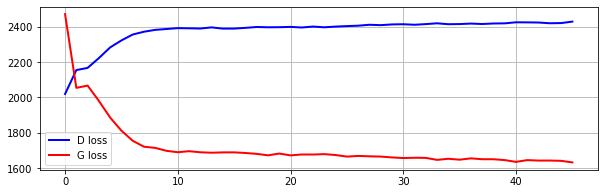

In [23]:
plt.figure(figsize=(10,3));
plt.plot(disc_losses, color='blue', label='D loss', linewidth=2)
plt.plot(gen_losses, color='red', label='G loss', linewidth=2)
#plt.yticks(range(4))
plt.legend()
plt.grid();

### Покажем, что Генератор G умеет синтезировать случайные изображения цифр x по некоторому входному латентному вектору h, который семплируется из нормального распределения.

torch.Size([16, 100]) torch.Size([16, 1, 28, 28])


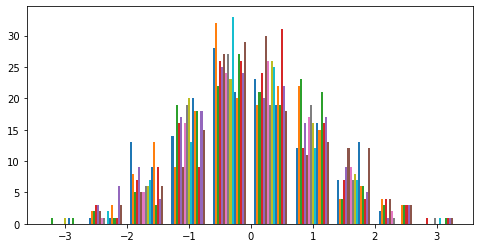

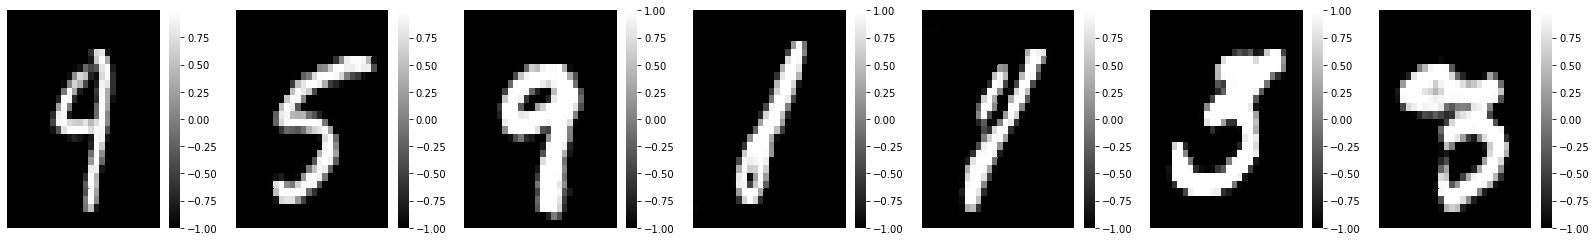

In [19]:
fixed_samples = random_noise_generator(16, 100) # семплируем из нормального распределения 16 векторов h
fixed_samples_cuda = fixed_samples.to(device)
G.eval()        
samples = G(fixed_samples_cuda.float()) # прогоняем их через генератор

plt.figure(figsize=(8,4))
plt.hist(fixed_samples); # показываем, что распределение действительно нормальное (по построению)

print(fixed_samples.shape,samples.shape)

k = 7 # визуализируем первые k синтезированные изображения из 16 сгенерированных
fig, ax = plt.subplots(1, k, figsize=(4*k,4))
for i in range(len(samples[:k])):
    x = samples[i].cpu().detach()
    sns.heatmap(data=x.view(28,28),cmap='gray', xticklabels=False, yticklabels=False, ax=ax[i])